# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

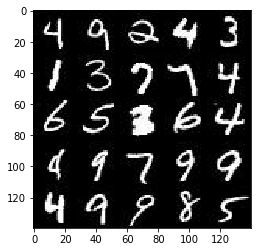

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

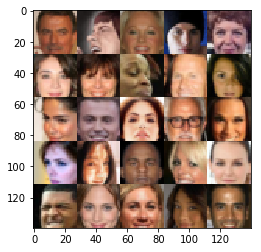

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import tensorflow as tf
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], 'input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], 'input_z')
    learning_rate_pl = tf.placeholder(tf.float32, [], 'learning_rate')

    return inputs_real, inputs_z, learning_rate_pl


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=.1, keep_prob=.7):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.01)
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # First layer 
        conv_1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                                  kernel_regularizer=regularizer,
                                  kernel_initializer=initializer)
        relu_1 = tf.maximum(alpha * conv_1, conv_1)
        relu_1_drop = tf.layers.dropout(relu_1, keep_prob)
        
        # second layer
        conv_2 = tf.layers.conv2d(relu_1_drop, 256, 5, strides=2, padding='same',
                                  kernel_regularizer=regularizer,
                                  kernel_initializer=initializer)
        bn_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        relu_2_drop = tf.layers.dropout(relu_2, keep_prob)
        
        # Third layer
        conv_3 = tf.layers.conv2d(relu_2_drop, 512, 5, strides=2, padding='same',
                                  kernel_regularizer=regularizer,
                                  kernel_initializer=initializer)
        bn_3 = tf.layers.batch_normalization(conv_3, training=True)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)
        relu_3_drop = tf.layers.dropout(relu_3, keep_prob)
        
        # Final fully connected layer
        shape = relu_3_drop.get_shape().as_list()[1:]
        flat_dim = shape[0] * shape[1] * shape[2]
        flat = tf.reshape(relu_3, [-1, flat_dim])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=.1, keep_prob=.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        fc_1 = tf.layers.dense(z, 4*4*512, kernel_regularizer=regularizer)
        reshaped = tf.reshape(fc_1, (-1, 4, 4, 512))
        bn_1 = tf.layers.batch_normalization(reshaped, training=is_train)
        relu_1 = tf.maximum(alpha * bn_1, bn_1)
        relu_1_drop = tf.layers.dropout(relu_1, keep_prob)
    
        
        # First upsampling
        deconv_2 = tf.layers.conv2d_transpose(relu_1, 256, 4, strides=1, padding='valid',
                                              kernel_regularizer=regularizer,
                                              kernel_initializer=initializer)
        bn_2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        
        # Fully convoluted layer
        f_deconv_2 = tf.layers.conv2d_transpose(relu_2, 256, 1, strides=1, 
                                                padding='same', 
                                                kernel_regularizer=regularizer,
                                                kernel_initializer=initializer)
                                            
        f_bn_2 = tf.layers.batch_normalization(f_deconv_2, training=is_train)
        f_relu_2 = tf.maximum(alpha * f_bn_2, f_bn_2)
        f_relu_2_drop = tf.layers.dropout(f_relu_2, keep_prob)
        
        
        # Second upsampling
        deconv_3 = tf.layers.conv2d_transpose(f_relu_2_drop, 128, 4, strides=2, 
                                              padding='same', 
                                              kernel_regularizer=regularizer,
                                              kernel_initializer=initializer)
        bn_3 = tf.layers.batch_normalization(deconv_3, training=is_train)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)
        
        # Fully convoluted layer
        f_deconv_3 = tf.layers.conv2d_transpose(relu_3, 128, 1, strides=1, 
                                                padding='same', 
                                                kernel_regularizer=regularizer,
                                                kernel_initializer=initializer)
        f_bn_3 = tf.layers.batch_normalization(f_deconv_3, training=is_train)
        f_relu_3 = tf.maximum(alpha * f_bn_3, f_bn_3)
        f_relu_3_drop = tf.layers.dropout(f_relu_3, keep_prob)
        
        
        # Final upsampling
        logits = tf.layers.conv2d_transpose(
            f_relu_3_drop, out_channel_dim, 5, strides=2, padding='same', 
            kernel_regularizer=regularizer,
            kernel_initializer=initializer)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # discriiminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    d_reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, scope='discriminator')
    
    #d_loss = tf.add_n([d_loss_real] + [d_loss_fake] + d_reg_loss)
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)))

    g_reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES, scope='generator')
    #g_loss = tf.add_n([g_loss] + g_reg_losses)
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
  
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(g_update_ops):  
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    with tf.control_dependencies(d_update_ops):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    #pyplot.show()
    return images_grid

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
import skimage.io as io

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, 
          data_image_mode, dest_dir = "generated/mnist"):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    with tf.Graph().as_default():
        tf.logging.set_verbosity(tf.logging.INFO)
        
        inputs_real, inputs_z, learning_rate_pl = model_inputs(*data_shape[1:], z_dim)
        d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
        d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate_pl, beta1)  

        steps = 0

        saver = tf.train.Saver()  
        tf.summary.scalar('losses/d_loss', d_loss)
        tf.summary.scalar('losses/g_loss', g_loss)
        merged_summary_op = tf.summary.merge_all()
        summary_string_writer = tf.summary.FileWriter('logs')
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch_i in range(epoch_count):
                for batch_images in get_batches(batch_size):
                    # TODO: Train Model
                    steps += 1
                    batch_images = batch_images * 2
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                    _ = sess.run(d_train_op, feed_dict={inputs_real: batch_images, 
                                                        inputs_z: batch_z, 
                                                        learning_rate_pl:learning_rate})
                    _ = sess.run(g_train_op, feed_dict={inputs_z: batch_z,
                                                       learning_rate_pl:learning_rate})

                    if steps % print_every == 0:
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                        train_loss_g = g_loss.eval({inputs_z: batch_z})

                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))

                    if steps % show_every == 0:
                        generated = show_generator_output(sess, 25, inputs_z, data_shape[-1], data_image_mode)
                        pyplot.show()
                        
                    if steps % write_every == 0:
                        summary_string = sess.run(merged_summary_op,
                                                 feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                        summary_string_writer.add_summary(summary_string, steps)
                        generated = show_generator_output(sess, 25, inputs_z, data_shape[-1], data_image_mode)
                        img_name = str(steps) + ".png"
                        img_path = os.path.join(dest_dir, img_name)
                        pyplot.imsave(img_path, generated)

            saver.save(sess, './checkpoints/generator.ckpt')


        return 


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 9.0840
Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 1.1274
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 2.2721
Epoch 1/2... Discriminator Loss: 1.6650... Generator Loss: 0.3891
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 1.7358
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.5486
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 2.0496
Epoch 1/2... Discriminator Loss: 2.4689... Generator Loss: 2.8988
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.6434... Generator Loss: 0.3171


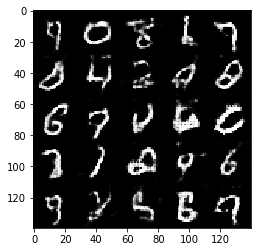

Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 1.4969
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 1.2848
Epoch 1/2... Discriminator Loss: 1.8162... Generator Loss: 0.2556
Epoch 1/2... Discriminator Loss: 1.2099... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.3099
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.4313
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 0.8983
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 1.4850


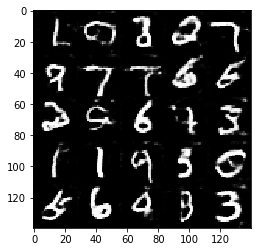

Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 1.6039... Generator Loss: 0.3713
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.5156


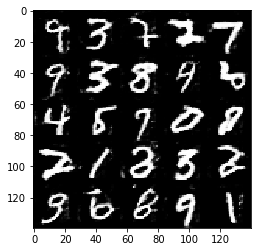

Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.6073
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 1.1829... Generator Loss: 0.6440
Epoch 2/2... Discriminator Loss: 1.1776... Generator Loss: 0.8534


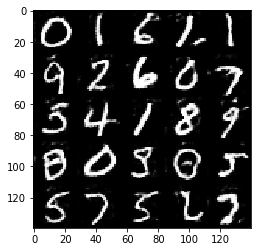

In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
print_every = 50
show_every = 500
write_every = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4872... Generator Loss: 3.3939
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.0385


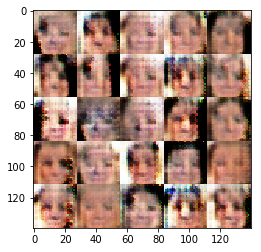

Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 2.4454... Generator Loss: 0.1439
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 2.5345
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 1.5936
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 3.6777... Generator Loss: 3.3176
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.1095


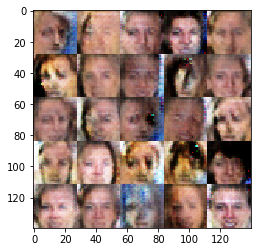

Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 1.6207
Epoch 1/1... Discriminator Loss: 1.7067... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7380


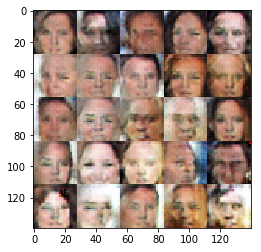

Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.8774... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 2.7314
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.9605


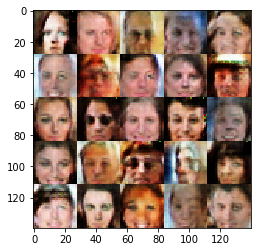

Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.5383


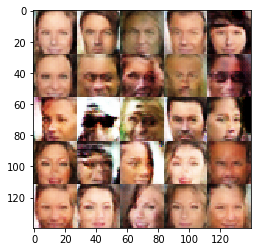

Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.3719


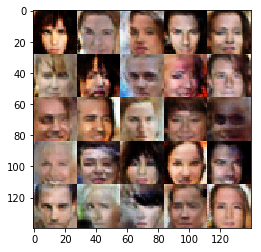

Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 0.8546


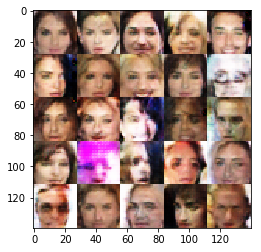

In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
print_every = 100
show_every = 1000
write_every = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, dest_dir="generated/celeba")

Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 1.3978
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.3512
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.3027
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 0.7045... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 1.7402... Generator Loss: 0.3170
Epoch 1/2... Discriminator Loss: 0.8631... Generator Loss: 0.8276
Epoch 1/2... Discriminator Loss: 2.7800... Generator Loss: 0.1536
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.3755


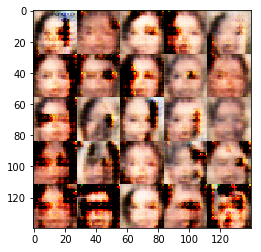

Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 1.4057
Epoch 1/2... Discriminator Loss: 0.6445... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 0.9888... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 0.6042... Generator Loss: 0.9996


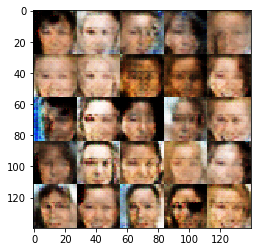

Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 1.5968
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.8070
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.7355


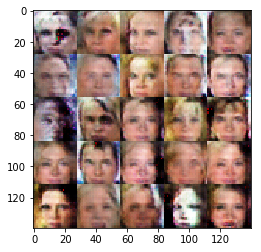

Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 0.9934... Generator Loss: 1.0881
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 0.8353... Generator Loss: 1.0594
Epoch 1/2... Discriminator Loss: 1.5282... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 1.2758
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.9122


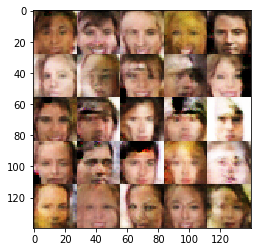

Epoch 1/2... Discriminator Loss: 0.8618... Generator Loss: 1.1295
Epoch 1/2... Discriminator Loss: 1.8143... Generator Loss: 2.2738
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 1.6193... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.5938
Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 0.4154


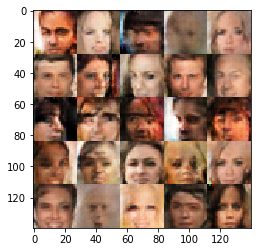

Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 1.0209
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.2162
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.6182
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.9392


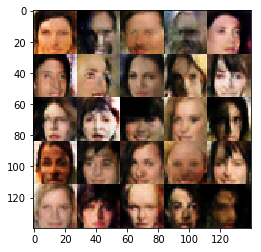

Epoch 1/2... Discriminator Loss: 1.7342... Generator Loss: 0.2802
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 1.0673
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 0.5874


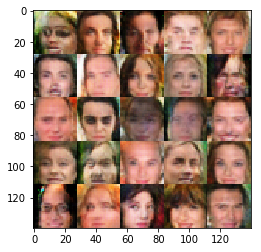

Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.5595
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.4920
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 0.8300


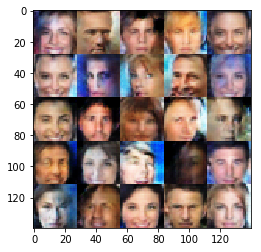

Epoch 2/2... Discriminator Loss: 1.1040... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.6701
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.1262... Generator Loss: 0.9932
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.8043


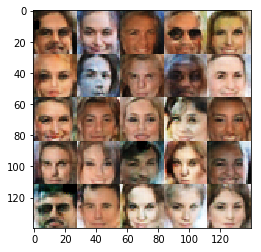

Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.3329
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6731
Epoch 2/2... Discriminator Loss: 1.2488... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 1.0437... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.3105


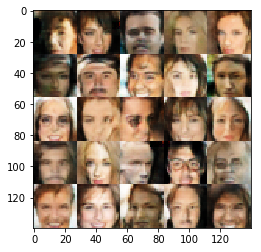

Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 0.8019
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.0635
Epoch 2/2... Discriminator Loss: 1.6098... Generator Loss: 1.5851
Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 0.5239
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 0.5175


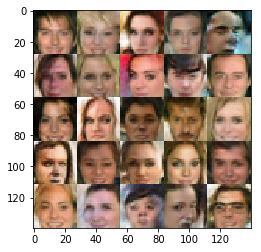

Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 0.9881
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 1.0584
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 0.5508
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 0.9315


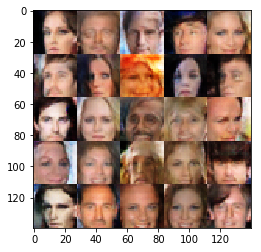

Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.5333
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 0.8344
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 0.8227
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.6476
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 0.9128


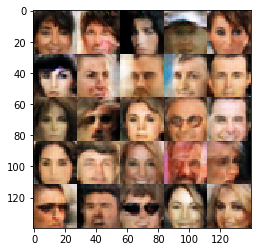

In [29]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
print_every = 100
show_every = 1000
write_every = 50
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, dest_dir="generated/celeba")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.